In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../casa/")
from plot_utils import *
from genome_utils import *

# General Setup
This is a small analysis of _CD164_.

Collecting files here.

In [2]:
CDR1_fn = '../data/CD164_rep1detailed.txt'
CDR2_fn = '../data/CD164_rep2detailed.txt'

fn_list = [CDR1_fn,CDR2_fn]

exp_ids = ['CDR1','CDR2']

fullinfo= [("CD164",1), ("CD164",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [3]:
OR_str = 'medOR'
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
CDR1_bed= '../data/CD164_rep1__{}peaks.bed'.format(OR_str)
CDR2_bed= '../data/CD164_rep2__{}peaks.bed'.format(OR_str)

exp_beds= [CDR1_bed, CDR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

# Load and preprocess data

In [4]:
gff = pd.read_table('../data/CD164_locus.gff')

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000368972.7,chr6,+,108848415,108974472,108876174,108973514,17,"108848415,108854224,108868823,108876142,108894...","108848546,108854485,108868995,108876350,108894...",Q8NEN0,uc011eao.3,ARMC2
1,ENST00000302071.6,chr6,-,108986441,109008988,108987543,109001458,10,"108986441,108988542,108990644,108992786,108994...","108987630,108988687,108990835,108992899,108994...",Q9Y6P5,uc021zdp.2,SESN1
2,ENST00000521277.5,chr6,+,109095109,109158488,109145221,109155889,8,"109095109,109106034,109145218,109146757,109150...","109095575,109106090,109145381,109146937,109150...",E5RJH1,uc063qmn.1,CEP57L1
3,ENST00000310786.10,chr6,-,109366513,109382467,109368850,109382378,6,"109366513,109370410,109376073,109377899,109379...","109369017,109370467,109376112,109377971,109379...",Q04900,uc003pte.6,CD164
4,ENST00000521072.6,chr6,-,109390214,109441171,109392825,109440590,8,"109390214,109400034,109419186,109426846,109427...","109392937,109400170,109419243,109426994,109427...",Q8IXY8,uc003ptg.4,PPIL6
5,ENST00000358577.7,chr6,-,109444061,109455742,109444190,109454196,24,"109444061,109444724,109444895,109445196,109445...","109444339,109444798,109444995,109445290,109445...",Q8TDZ2,uc010kdr.4,MICAL1
6,ENST00000258052.8,chr6,+,109440723,109443919,109441121,109443905,10,"109440723,109441356,109441551,109441973,109442...","109441171,109441453,109441628,109442067,109442...",O60906,uc003pti.5,SMPD2
7,ENST00000230122.3,chr6,-,109462593,109483237,109465850,109482026,7,"109462593,109467652,109475398,109476174,109476...","109466574,109467734,109475482,109476258,109476...",O43167,uc003ptl.2,ZBTB24
8,ENST00000424296.6,chr6,-,109492855,109691212,109493368,109675745,41,"109492855,109493980,109495337,109497464,109497...","109493571,109494095,109495440,109497563,109497...",Q5TCS8,uc003ptn.2,AK9
9,ENST00000368941.1,chr6,+,109716505,109743480,109716510,109743114,5,"109716505,109727108,109732636,109735149,109743109","109716568,109727265,109732687,109735298,109743480",Q5TCS4,uc063qon.1,FIG4


In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("CTRL")) &\
                           (~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [8]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [9]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ]
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


Experimental track count: 2
Total track count: 4


/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.


# Plot guide-wise scores with peaks
Lines indicate min-max interval between all replicates.

CD164
37


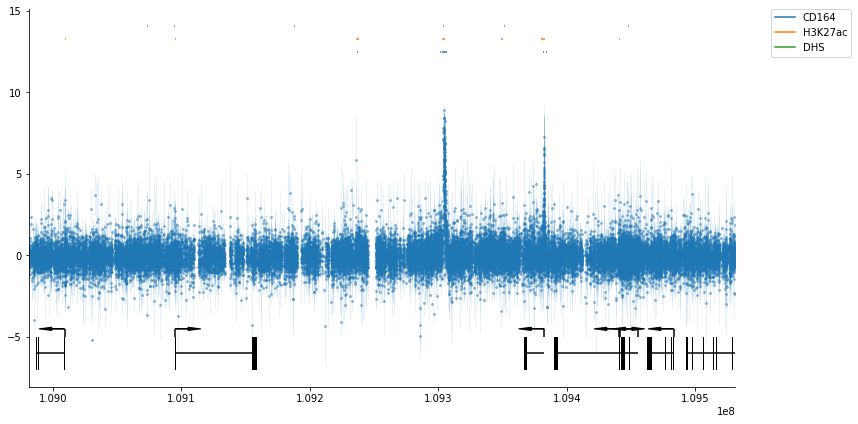

In [10]:
fig_h, ax_h = plot_combined_cutsites(np.array([[108981232,109531381]]), 
          data, test_peaks, plot_ids=['CDR1','CDR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[10000,0.2,10000])
fig_h.savefig('plots/CD164_locus__108981232_109531381__all.pdf')

# Connection diagram
Summarize CRE promoter interactions

In [11]:
txn_starts = extract_txn_starts(gff)

pack_TSSs   = [('CD164',txn_starts['CD164'][0],txn_starts['CD164'][1])]

In [12]:
txn_starts

{'ARMC2': ('chr6', 108848415),
 'SESN1': ('chr6', 109008988),
 'CEP57L1': ('chr6', 109095109),
 'CD164': ('chr6', 109382467),
 'PPIL6': ('chr6', 109441171),
 'MICAL1': ('chr6', 109455742),
 'SMPD2': ('chr6', 109440723),
 'ZBTB24': ('chr6', 109483237),
 'AK9': ('chr6', 109691212),
 'FIG4': ('chr6', 109716505)}

In [13]:
CD164_only_peaks = filter_by_guide_coverage(
    get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'CD164')] ), 
    pd.read_table(CDR1_fn,sep='\t',header=0)['Coordinates'], min_coverage=29
)

pack_peaks       = [CD164_only_peaks]

all_locus_peaks = pd.concat(pack_peaks).reset_index(drop=True)

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
all_locus_peaks

,chr,start,end,guide_coverage
0,chr6,109236645,109237345,73
1,chr6,109301445,109302345,137
2,chr6,109303145,109306545,287
3,chr6,109308045,109308645,82
4,chr6,109381245,109382645,277


In [15]:
# CD164
CD164_total_scores = get_peak_strengths(CDR1_bed, CDR2_bed)

pack_scores = [CD164_total_scores]


../casa/plot_utils.py:312: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  for fn in argv ]


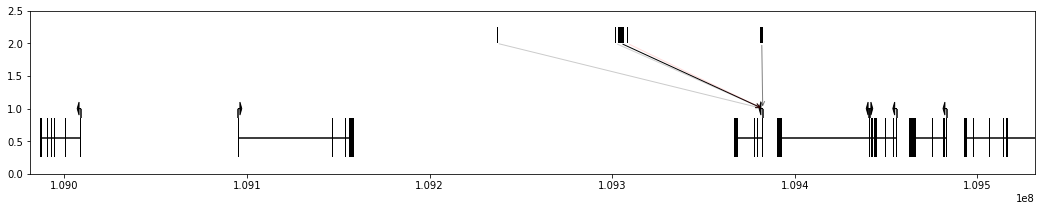

In [16]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [108981232,109531381]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['CD164'], y_anchor=2.0, y_target=1.0, score_bed=CD164_total_scores, xlims=glims)

plt.savefig('CD164_locus__108981232_109531381__connectogram__{}.pdf'.format(OR_str))

plt.show()

In [17]:
write_bed_format([ x.iloc[:,0:3] for x in pack_peaks ], pack_scores, pack_TSSs, 
                 '../data/CD164__replicating_peaks__{}.bed'.format(OR_str))